In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, feature_extraction, preprocessing, svm, pipeline, metrics, tree, linear_model
import json
import matplotlib.pyplot as plt
import itertools
from project_utilities import plot_confusion_matrix
import time

# Raw Data

In [2]:
with open('train_data.json') as fd:
    train_data = pd.DataFrame(json.load(fd))
    
with open('test_data.json') as fd:
    test_data = pd.DataFrame(json.load(fd))

It's good to use 80% and 20% of the dataset for training and testing respectively.

In [3]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
    train_data.drop(columns=['category']), 
    train_data.drop(columns=['text']), 
    test_size=0.2)

# Experimenting with Different Classifiers

The following experiments are already using pipelining. The pipeline structures the raw data. It also extracts and selects features from the structured data.

## Logistic Regression

In [4]:
clf_pipeline_logistic_reg = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', linear_model.LogisticRegression())])

clf_pipeline_logistic_reg.fit(X_train['text'], y_train);

C:\Users\matth\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\matth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [5]:
logistic_reg_predictions = clf_pipeline_logistic_reg.predict(X_validation['text'])

print(metrics.classification_report(y_validation, logistic_reg_predictions,digits=5))

              precision    recall  f1-score   support

           0    0.87202   0.84726   0.85946      2501
           1    0.85136   0.87555   0.86329      2499

   micro avg    0.86140   0.86140   0.86140      5000
   macro avg    0.86169   0.86141   0.86137      5000
weighted avg    0.86169   0.86140   0.86137      5000



## Decision Tree

In [6]:
clf_pipeline_tree = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', tree.DecisionTreeClassifier())])
start = time.time()
clf_pipeline_tree.fit(X_train['text'], y_train);

### Prediction on Validation Set

In [7]:
tree_predictions = clf_pipeline_tree.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, tree_predictions,digits=5))
print("time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.70269   0.70972   0.70619      2501
           1    0.70655   0.69948   0.70300      2499

   micro avg    0.70460   0.70460   0.70460      5000
   macro avg    0.70462   0.70460   0.70459      5000
weighted avg    0.70462   0.70460   0.70459      5000

time: 30.663408994674683


## SVM

In [8]:
clf_pipeline_svm = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm.fit(X_train['text'], y_train);

C:\Users\matth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Prediction on Validation Set

In [9]:
svm_predictions = clf_pipeline_svm.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_predictions,digits=5))
print("time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.89898   0.87885   0.88880      2501
           1    0.88141   0.90116   0.89118      2499

   micro avg    0.89000   0.89000   0.89000      5000
   macro avg    0.89019   0.89000   0.88999      5000
weighted avg    0.89020   0.89000   0.88999      5000

time: 5.284643888473511


# Experimenting with Different Feature Extraction Pipelines

## Binary Occurences

In [10]:
clf_pipeline_svm_bin = pipeline.Pipeline([
    ('vect', feature_extraction.text.HashingVectorizer(binary=True)),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_bin.fit(X_train['text'], y_train);

### Prediction on Validation Set

In [11]:
svm_bin_predictions = clf_pipeline_svm_bin.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_bin_predictions,digits=5))
print("Time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.89230   0.87125   0.88165      2501
           1    0.87412   0.89476   0.88432      2499

   micro avg    0.88300   0.88300   0.88300      5000
   macro avg    0.88321   0.88300   0.88298      5000
weighted avg    0.88321   0.88300   0.88298      5000

Time: 4.665310382843018


## TF-IDF Weighting

In [12]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer()),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

### Prediction on Validation Set

In [13]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.90595   0.88205   0.89384      2501
           1    0.88499   0.90836   0.89652      2499

   micro avg    0.89520   0.89520   0.89520      5000
   macro avg    0.89547   0.89521   0.89518      5000
weighted avg    0.89548   0.89520   0.89518      5000

Time: 5.321075201034546


## Custom Parameters
These parameters will used in GridResearch and RandomResearch to see if they can improve accuracy.<br>

textblob_tokenizer, stemming_tokenizer, token.tokenize, and nltk.word_tokenize are the custom paramerters for the tokenizing process in CountVectorizer.

In [14]:
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
import re
porter_stemmer = PorterStemmer()

# Try TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

# Try NLTK's PorterStemmer
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [15]:
import nltk
nltk.download('punkt');

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### SVM+OccurenceCount+TF*IDF+textblob tokenizer

In [17]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = textblob_tokenizer)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

In [18]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.90670   0.88205   0.89420      2501
           1    0.88508   0.90916   0.89696      2499

   micro avg    0.89560   0.89560   0.89560      5000
   macro avg    0.89589   0.89561   0.89558      5000
weighted avg    0.89589   0.89560   0.89558      5000

Time: 172.06548142433167


### SVM+OccurenceCount+TF*IDF+stemming tokenizer

In [19]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = stemming_tokenizer)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

In [20]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.90370   0.87805   0.89069      2501
           1    0.88132   0.90636   0.89367      2499

   micro avg    0.89220   0.89220   0.89220      5000
   macro avg    0.89251   0.89221   0.89218      5000
weighted avg    0.89252   0.89220   0.89218      5000

Time: 110.30972719192505


### SVM+OccurenceCount+TF*IDF+nltk.word tokenize

In [21]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = nltk.word_tokenize)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

In [22]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.90577   0.89164   0.89865      2501
           1    0.89322   0.90716   0.90014      2499

   micro avg    0.89940   0.89940   0.89940      5000
   macro avg    0.89950   0.89940   0.89939      5000
weighted avg    0.89950   0.89940   0.89939      5000

Time: 46.059377908706665


### SVM+OccurenceCount+TF*IDF+token.tokenize

In [23]:
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [24]:
clf_pipeline_svm_tfidf = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = token.tokenize)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])
start = time.time()
clf_pipeline_svm_tfidf.fit(X_train['text'], y_train);

In [25]:
svm_tfidf_predictions = clf_pipeline_svm_tfidf.predict(X_validation['text'])
diff = time.time() - start
print(metrics.classification_report(y_validation, svm_tfidf_predictions,digits=5))
print("Time: {}".format(diff))

              precision    recall  f1-score   support

           0    0.90768   0.88844   0.89796      2501
           1    0.89067   0.90956   0.90002      2499

   micro avg    0.89900   0.89900   0.89900      5000
   macro avg    0.89918   0.89900   0.89899      5000
weighted avg    0.89918   0.89900   0.89899      5000

Time: 4.629029273986816


## Using TF-IDF and Linear SVM

In [26]:
clf_pipeline_svm = pipeline.Pipeline([
    ('vect', feature_extraction.text.CountVectorizer(tokenizer = token.tokenize)),
    ('tfidf', feature_extraction.text.TfidfTransformer()),
    ('norm', preprocessing.Normalizer()),
    ('clf', svm.LinearSVC())])

parameters = {'vect__ngram_range': [(1,1), (1,2), (2,2)],
              'vect__binary': [True],
              'vect__analyzer':['word'],
              'vect__strip_accents': ['unicode'],
              'tfidf__norm': ['l1'],
              'tfidf__smooth_idf': [False],
              'clf__C':[1, 10],}

### With Randomized Search CV

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform

seed = 42

random_search = RandomizedSearchCV(clf_pipeline_svm, param_distributions = parameters, cv=3, verbose = 10, random_state = seed, n_iter = 5, n_jobs=6)
random_search.fit(X_train['text'], y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=6)]: Done   6 out of  15 | elapsed:   52.9s remaining:  1.3min
[Parallel(n_jobs=6)]: Done   8 out of  15 | elapsed:  1.1min remaining:   56.6s
[Parallel(n_jobs=6)]: Done  10 out of  15 | elapsed:  1.5min remaining:   44.5s
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:  1.5min remaining:   22.5s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  1.9min finished
C:\Users\matth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Prediction on Validation Set

In [44]:
y_pred_randcv = random_search.predict(X_validation['text'])
print(metrics.classification_report(y_validation, y_pred_randcv))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2501
           1       0.90      0.91      0.91      2499

   micro avg       0.91      0.91      0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



### With Grid Search CV

This is our best classifier so far!

In [45]:
grid_search_cv = model_selection.GridSearchCV(clf_pipeline_svm, parameters, cv=3, n_jobs=6, verbose=10, error_score=0)
grid_search_cv.fit(X_train['text'], y_train)

print('Best Parameters:', grid_search_cv.best_params_);

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   15.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   50.4s
[Parallel(n_jobs=6)]: Done   9 out of  18 | elapsed:   54.8s remaining:   54.8s
[Parallel(n_jobs=6)]: Done  11 out of  18 | elapsed:  1.1min remaining:   43.7s
[Parallel(n_jobs=6)]: Done  13 out of  18 | elapsed:  1.9min remaining:   44.9s
[Parallel(n_jobs=6)]: Done  15 out of  18 | elapsed:  2.0min remaining:   23.4s
[Parallel(n_jobs=6)]: Done  18 out of  18 | elapsed:  2.0min finished
C:\Users\matth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'clf__C': 10, 'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'vect__analyzer': 'word', 'vect__binary': True, 'vect__ngram_range': (1, 2), 'vect__strip_accents': 'unicode'}


#### Prediction on Validation Set

In [46]:
predictions = grid_search_cv.predict(X_validation['text'])

print(metrics.classification.classification_report(y_validation, predictions))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2501
           1       0.90      0.91      0.91      2499

   micro avg       0.91      0.91      0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



## Confusion Matrix Visualization

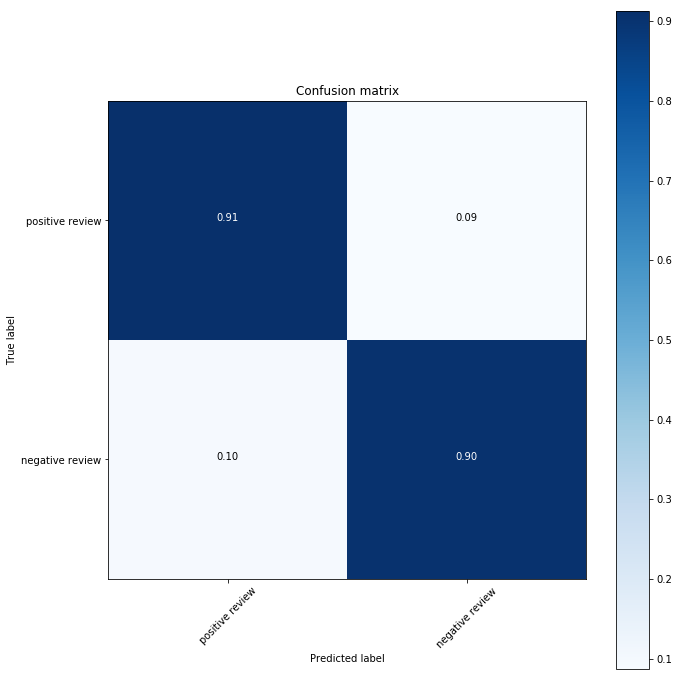

In [47]:
plot_confusion_matrix(metrics.confusion_matrix(predictions, y_validation), ['positive review', 'negative review'], normalize=True)

# Prediction on Test Set Using Our Best Classifier

In [40]:
test_set_predictions = grid_search_cv.predict(test_data['text'])

data = {'Id' : test_data['id'], 'Category': test_set_predictions}
submission = pd.DataFrame(data=data)
submission = submission.apply(pd.to_numeric).sort_values(by=['Id'])

In [41]:
submission.to_csv('submission.csv', encoding='utf-8', index=False)